In [22]:
# Importações

import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
from sklearn import preprocessing, model_selection, metrics
import numpy as np

Adicionando as configurações de diretório e outros artefatos para o modelo

In [24]:
# diretorio da localização das imagens de treino
DIR = r"C:\Users\perei\Desktop\universidade\inteligencia artificial\utfpr_ia"
CATEGORIAS = ['mask', 'no_mask']

# iniciando os arrays de Data e labels vazios
data = []
labels = []

Adicionando as imagens de treino

In [25]:
for categoria in CATEGORIAS:
    path = os.path.join(DIR, categoria)
    for imagem in os.listdir(path):
        image_path = os.path.join(path, imagem)
        image = keras.preprocessing.image.load_img(image_path, target_size=(224,224))
        image = keras.preprocessing.image.img_to_array(image)
        image = keras.applications.mobilenet_v2.preprocess_input(image)

        data.append(image)
        labels.append(categoria)

C:\Users\perei\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Transformando valores categóricos em vetores binários esparso

In [26]:
bin_labels = preprocessing.LabelBinarizer()
labels = bin_labels.fit_transform(labels)
labels = keras.utils.to_categorical(labels)

Convertendo os arrays de data e labels para o formato float32 com o numpy

In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

Splitando o array em subset de testes e trainamento

In [6]:
(trainX, testX, trainY, testY) = model_selection.train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

Gerador de imagem de treinamento

In [7]:
aumento = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.15, horizontal_flip=True,
    fill_mode="nearest"
)

Carregamento da rede MobileNetV2

In [8]:
modeloBase = keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3))
)

cabecalhoModelo = modeloBase.output
cabecalhoModelo = keras.layers.AveragePooling2D(pool_size=(7,7))(cabecalhoModelo)
cabecalhoModelo = keras.layers.Flatten(name="flatten")(cabecalhoModelo)
cabecalhoModelo = keras.layers.Dense(128, activation="relu")(cabecalhoModelo)
cabecalhoModelo = keras.layers.Dropout(0.5)(cabecalhoModelo)
cabecalhoModelo = keras.layers.Dense(2, activation="softmax")(cabecalhoModelo)

Criando o modelo de treinamento

In [9]:
modelo = keras.Model(inputs=modeloBase.input, outputs=cabecalhoModelo)

Fazendo um loop em cima das camadas do modelo base

In [10]:
for camada in modeloBase.layers:
    camada.trainable = False

Compilando o nosso modelo

In [11]:
# algumas definições
EPOCAS = 20

# definindo o otimizador
otimizador = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-4/EPOCAS)

modelo.compile(loss="binary_crossentropy", optimizer=otimizador, metrics=['accuracy'])

Treinando o cabeçalho da rede

In [12]:
head = modelo.fit(
    aumento.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=EPOCAS
)

Epoch 1/20
95/95 [==============================] - 159s 2s/step - loss: 0.4268 - accuracy: 0.8375 - val_loss: 0.1540 - val_accuracy: 0.9844
Epoch 2/20
95/95 [==============================] - 135s 1s/step - loss: 0.1560 - accuracy: 0.9611 - val_loss: 0.0805 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 138s 1s/step - loss: 0.0991 - accuracy: 0.9789 - val_loss: 0.0594 - val_accuracy: 0.9896
Epoch 4/20
95/95 [==============================] - 141s 1s/step - loss: 0.0873 - accuracy: 0.9769 - val_loss: 0.0484 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 139s 1s/step - loss: 0.0754 - accuracy: 0.9782 - val_loss: 0.0454 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 140s 1s/step - loss: 0.0629 - accuracy: 0.9802 - val_loss: 0.0434 - val_accuracy: 0.9896
Epoch 7/20
95/95 [==============================] - 136s 1s/step - loss: 0.0529 - accuracy: 0.9858 - val_loss: 0.0408 - val_accuracy: 0.9870
Epoch 8/20
95

Realizando teste no modelo salvo

In [13]:
predIdxs = modelo.predict(testX, batch_size=32)

Para cada imagem no set de teste, precisamos do indice da label com mais probabilidade de predição

In [14]:
predIdxs = np.argmax(predIdxs, axis=1)

Report de classificação

In [15]:
print(metrics.classification_report(testY.argmax(axis=1), predIdxs, target_names=bin_labels.classes_))

              precision    recall  f1-score   support

        mask       0.99      0.99      0.99       383
     no_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



Salvando o modelo

In [16]:
modelo.save("modelo_reconhecimento_mascara.h5")

C:\Users\perei\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Gráfico de acurácia e perda do modelo

Text(0.5, 0, 'Época')

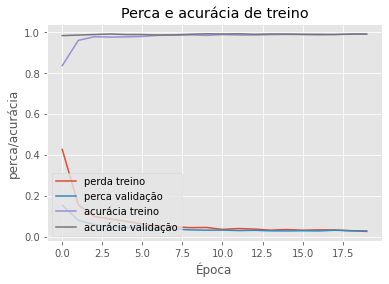

In [18]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,EPOCAS), head.history["loss"], label="perda treino")
plt.plot(np.arange(0,EPOCAS), head.history["val_loss"], label="perca validação")
plt.plot(np.arange(0,EPOCAS), head.history["accuracy"], label="acurácia treino")
plt.plot(np.arange(0,EPOCAS), head.history["val_accuracy"], label="acurácia validação")
plt.title("Perca e acurácia de treino")
plt.ylabel("perca/acurácia")
plt.legend(loc="lower left")
plt.xlabel("Época")